In [7]:
import pandas as pd
import scipy
import numpy as np
import copy
import os
import time
import sklearn
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from custom_utils import validation_setup, MLP_model, PhyC_model
from tensorflow.keras import backend as K
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

In [8]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
cardiotocography = fetch_ucirepo(id=193) 
  
# data (as pandas dataframes) 
X = cardiotocography.data.features 
y = cardiotocography.data.targets 
  
# # metadata 
# print(cardiotocography.metadata) 
  
# # variable information 
# print(cardiotocography.variables) 

scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X)
y = y[['NSP']].replace({1: 0, 2: 1, 3: 1})

/tmp/ipykernel_1996578/1373022637.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[X.columns] = scaler.fit_transform(X)


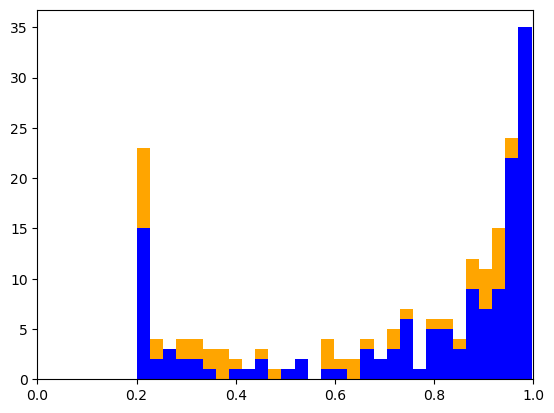

0.583762914677942 25 NSP    50
dtype: int64


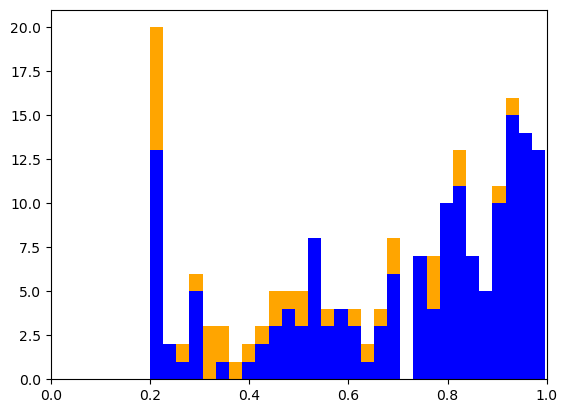

0.4826984636044488 14 NSP    35
dtype: int64


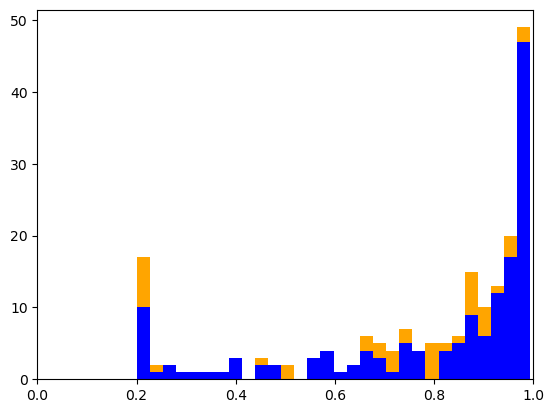

0.6905863224828355 35 NSP    43
dtype: int64


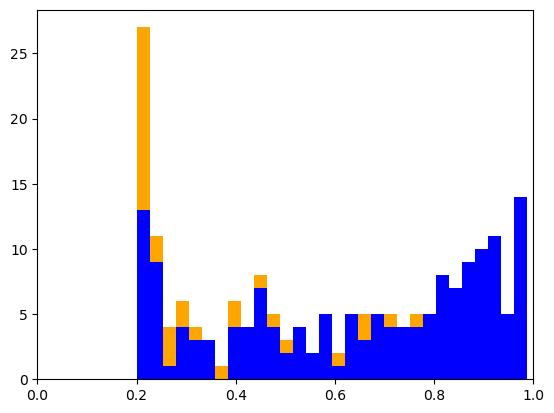

0.3362243886789024 10 NSP    33
dtype: int64


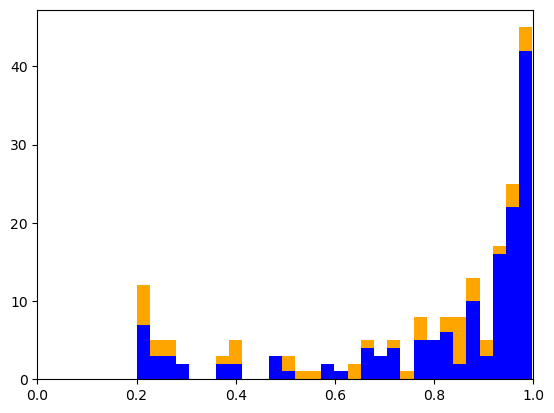

0.6530728263724528 27 NSP    45
dtype: int64


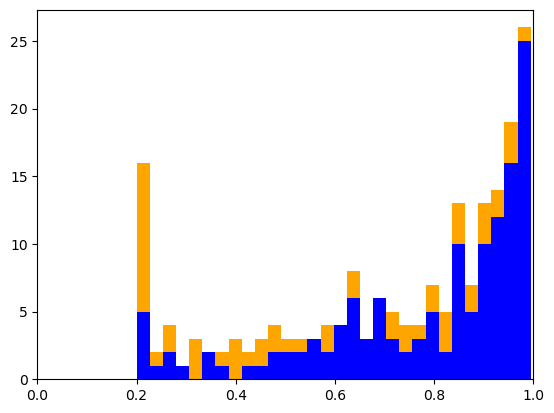

0.5682641030188537 32 NSP    56
dtype: int64


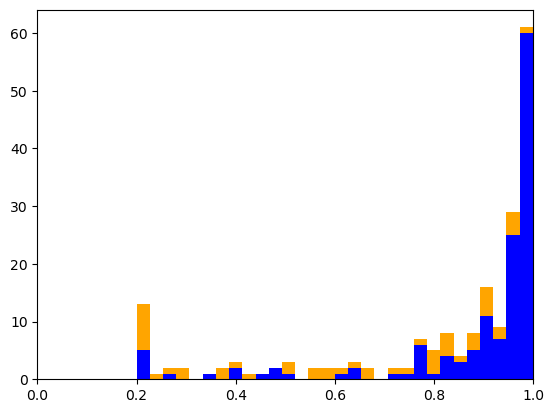

0.6359907485113627 32 NSP    53
dtype: int64


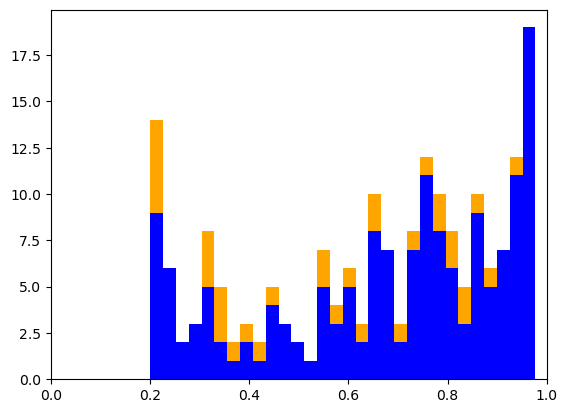

0.5462102293438554 17 NSP    34
dtype: int64


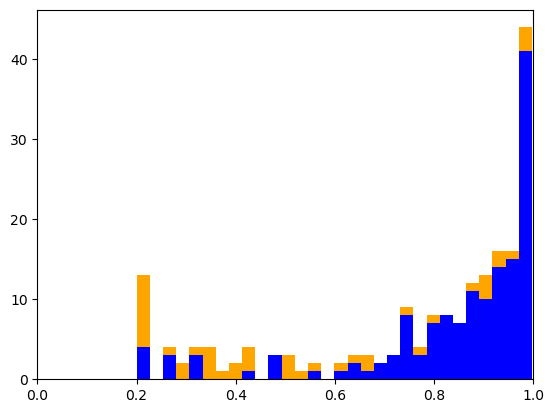

0.5273681479735456 23 NSP    45
dtype: int64


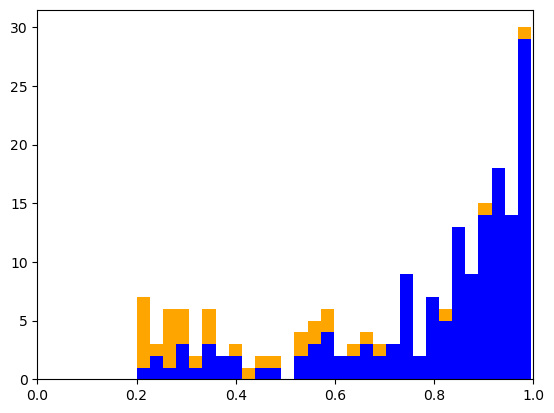

0.4217333955320706 18 NSP    35
dtype: int64


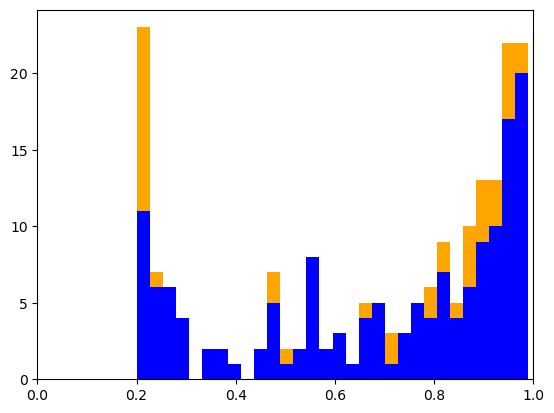

0.6365037385264622 28 NSP    42
dtype: int64


In [9]:
# parameters
n_folds, n_providers_per_fold = 11, 1
n_providers = n_folds * n_providers_per_fold
n_inputs = X.shape[1]
n_labels = y.shape[1]
col_labels = y.columns

batch_size = 10
n_iters = 40
epsilon = 1e-7 

# test with n_providers=11 for  11-fold LORS 5:5:1
kf = KFold(n_splits=n_providers, shuffle=True, random_state=42)
fold_index = [test_index for fold, (train_index, test_index) in enumerate(kf.split(X))]

# random table for each provider's propensity being affected by columns
np.random.seed(1)
random_table = np.random.uniform(-1,0,size=(n_providers, n_inputs * 2))


# generate s as pu label
s = copy.copy(y)

for i_provider in range(n_providers):

    index_provider = fold_index[i_provider]
    X_p = X.iloc[index_provider]
    y_p = y.iloc[index_provider]

    X_prop_columns = random_table[i_provider]
    X_p_double_side = np.hstack([np.maximum(X_p, 0),np.maximum(-X_p, 0)])
    X_prop = scipy.special.expit((X_p_double_side * X_prop_columns).sum(axis=1)+8)*0.8+0.2

    plt.hist([X_prop[y_p['NSP'] == 0], X_prop[y_p['NSP'] == 1]], bins=30, stacked=True, label=['Class 0', 'Class 1'], color=['blue', 'orange'])
    plt.xlim([0,1])
    plt.show()
    
    np.random.seed(55+i_provider)
    s_p = ((np.random.rand(X_prop.shape[0]) < X_prop) * y_p['NSP']).values
    
    s.iloc[index_provider, 0] = s_p

    print(np.sum(X_prop * y_p['NSP']) / np.sum(y_p['NSP']), s_p.sum(), y_p.sum()) 

### X: features, y: true label, s: propensity based label

In [10]:
train_folds, valid_folds = validation_setup(n_providers, 1)

In [12]:
for j_fold in range(n_folds):
            
    valid_pids = valid_folds[j_fold]
    valid_index = np.hstack([fold_index[ind] for ind in valid_pids])
    valid_inputs = X.iloc[valid_index]
    valid_labels = s.iloc[valid_index]
    valid_truths = y.iloc[valid_index]

    for i_fold in [0, 1]:

        # select training sets
        train_pids = train_folds[j_fold][i_fold]
        n_train_providers = len(train_pids)
        train_index = np.hstack([fold_index[ind] for ind in train_pids])
        train_inputs = X.iloc[train_index]
        train_labels = s.iloc[train_index]

        train_inputs.to_csv("./data/cardiotocography/train_inputs_fold_%d_split_%d.csv" % (j_fold, i_fold), index=False)
        train_labels.to_csv("./data/cardiotocography/train_labels_fold_%d_split_%d.csv" % (j_fold, i_fold), index=False)
        valid_inputs.to_csv("./data/cardiotocography/valid_inputs_fold_%d_split_%d.csv" % (j_fold, i_fold), index=False)
        valid_labels.to_csv("./data/cardiotocography/valid_labels_fold_%d_split_%d.csv" % (j_fold, i_fold), index=False)
        valid_truths.to_csv("./data/cardiotocography/valid_truths_fold_%d_split_%d.csv" % (j_fold, i_fold), index=False)
        
        bash_str = "python3 train.py -b %d -f %d -sp %d -g -1 -d 'cardiotocography' -l %d -u %d -e 100 -m 'mlp' --loss 'sigmoid' -o 'result/cardiotocography/f%dsp%d'" % (
            (train_labels.shape[0]+1) // 2, j_fold, i_fold, np.sum(train_labels == 1), train_labels.shape[0], j_fold, i_fold
        )

/tmp/ipykernel_1996578/1459763349.py:24: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  bash_str = "python3 train.py -b %d -f %d -sp %d -g -1 -d 'cardiotocography' -l %d -u %d -e 100 -m 'mlp' --loss 'sigmoid' -o 'result/cardiotocography/f%dsp%d'" % (


#### 